In [331]:
import numpy as np
import pandas as pd

data = pd.read_csv('time_series_dax.csv',sep = ';')
data.head()

,Date,Value,Volume
0,02.01.1990,1814.38,0
1,03.01.1990,1869.66,0
2,04.01.1990,1835.88,0
3,05.01.1990,1820.00,0
4,08.01.1990,1843.24,0


In [332]:
data = np.array(data)
data = data[0:,1]
data

array([1814.38, 1869.66, 1835.88, ..., 11270.67, 11391.78, 11417.09],
      dtype=object)

In [333]:
data = data.astype(int)
data1 = np.ediff1d(np.log(data))
data1

array([ 0.02986918, -0.01835905, -0.00820798, ...,  0.00801786,
        0.01067924,  0.0022799 ])

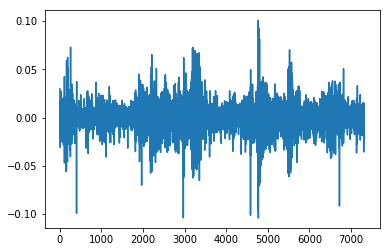

In [315]:
import matplotlib.pyplot as plt
plt.plot(data1)
plt.show()

In [334]:
# We have the sample size of T
T = len(data1)
# Initialize observed vectors y and x where y = (y2,y3,...yT) and x = (y1,y2,...yT-1)
y = data1.reshape(T,1)
y = y[1:]

In [335]:
x = np.ones((2,T-1))
x[1,:] = data1[:T-1]
x[:,-1]

array([1.        , 0.01067924])

In [365]:
## Initialize 
A = np.zeros((2,T)) # to save the probability P(st|yt)
B = np.zeros((2,T)) # to save the probability P(s(t+1)|yt)
C = np.zeros((2,T)) # to save the smoothed probability P(st|yT)

# Guess the initial parameters
beta1 = np.array([0,12])
beta2 = np.array([0,15])
sigma1 = 9
sigma2 = 4
P = np.array([[0.3,0.6],[0.7,0.4]]) # the transition matrix
A[:,0] = [0.6,0.4] 

In [366]:
beta1 = beta1.reshape(2,1)
beta2 = beta2.reshape(2,1)

def normal_density(sigma,beta,y,x):
    result = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(y-np.matmul(np.transpose(x),beta))**2/(2*sigma**2))
    return result

In [367]:
# Find the parameters beta1 and beta2 by OLS regression of y_tilde1 and 2 on x_tilde1 and 2 respectively
# beta = (X'X)^-1 * (X'Y)

def ols_regression(y,x,smooth_prob):
    y_tilde = y * np.sqrt(smooth_prob[1:])
    x_tilde = np.transpose(x) * np.sqrt(smooth_prob[:T-1])
    beta = np.matmul(np.linalg.inv(np.matmul(np.transpose(x_tilde),x_tilde)) , np.matmul(np.transpose(x_tilde),y_tilde))
    return beta
    

In [368]:
# Then find sigma by equation (8) and (9) in the seminar paper

def sigma(y,x,smooth_prob,beta):
    y_tilde = y * np.sqrt(smooth_prob[1:])
    x_tilde = np.transpose(x) * np.sqrt(smooth_prob[:T-1])
    variance = sum((y_tilde - np.matmul(x_tilde,beta))**2) / sum(smooth_prob[1:])
    sigma = np.sqrt(variance)
    return sigma

In [369]:
## Update the parameters

for i in range(0,100):
    
# Calculate the smoothed probability and filltering

    for t in range(0,T-1):
        B[:,[t]] = np.matmul(P, A[:,[t]])
        n = np.array([normal_density(sigma1,beta1,y[t],x[:,t]) , normal_density(sigma2,beta2,y[t],x[:,t])])
        A[:,[t+1]] = B[:,[t]] * n / sum(B[:,[t]] * n)
    
    C[:,T-1] = A[:,T-1]

    for t in range(0,T-1)[::-1]:
        temp1 = np.matmul(np.transpose(P) , C[:,[t+1]]/B[:,[t]] )
        C[:,[t]] = A[:,[t]] * temp1

    C1 = C[0,:].reshape(T,1) # convert 1d array to 2d array 
    C2 = C[1,:].reshape(T,1)
    A1 = A[0,:].reshape(T,1) # convert 1d array to 2d array 
    A2 = A[1,:].reshape(T,1)
    B1 = B[0,:].reshape(T,1) # convert 1d array to 2d array 
    B2 = B[1,:].reshape(T,1)

# parameters beta1 and beta2

    beta1 = ols_regression(y,x,C1)
    beta2 = ols_regression(y,x,C2)

# Find sigma

    sigma1 = sigma(y,x,C1,beta1)
    sigma2 = sigma(y,x,C2,beta2)

# update the transition probability using equation (4) and (5)

    numerator1 = sum(C1[1:] * A1[:T-1] / B1[:T-1]) * P[0,0]
    denominator1 = sum(C1[:T-1])
    P[0,0] = numerator1/denominator1
    P[1,0] = 1 - P[0,0]
    numerator2 = sum(C2[1:] * A2[:T-1] / B2[:T-1]) * P[1,1]
    denominator2 = sum(C2[:T-1])
    P[1,1] = numerator2/denominator2
    P[0,1] = 1 - P[1,1]

# update the probability of the initial unobserved states P(s1|y1) via equation (10)

    A[:,0] = C[:,0]

In [370]:
beta1

array([[0.00086171],
       [0.02436007]])

In [371]:
sigma1

array([0.00869089])

In [372]:
beta2

array([[-0.00118018],
       [-0.02427206]])

In [373]:
sigma2

array([0.02138522])

In [374]:
C

array([[2.84374635e-52, 6.58302143e-03, 3.31206033e-02, ...,
        5.94406648e-01, 6.38363114e-01, 6.63617415e-01],
       [1.00000000e+00, 9.93416979e-01, 9.66879397e-01, ...,
        4.05593352e-01, 3.61636886e-01, 3.36382585e-01]])

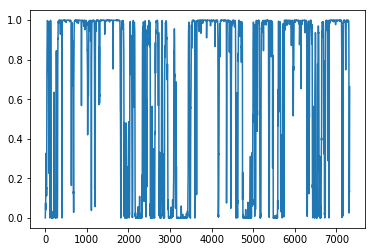

In [375]:
plt.plot(C[0,:])
plt.show()

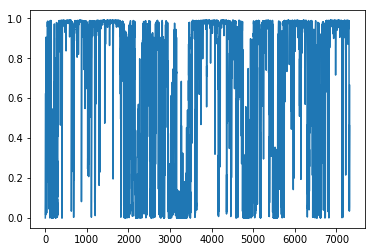

In [376]:
plt.plot(A[0,:])
plt.show()